In [2]:
# PCA on Wine data (red vs white friendly)
# ----------------------------------------
import io
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer


In [8]:
df = pd.read_csv('Wine.csv')

In [10]:
print("Shape:", df.shape)
print("Columns:", list(df.columns))
display(df.head())

Shape: (178, 14)
Columns: ['Alcohol', 'Malic_Acid', 'Ash', 'Ash_Alcanity', 'Magnesium', 'Total_Phenols', 'Flavanoids', 'Nonflavanoid_Phenols', 'Proanthocyanins', 'Color_Intensity', 'Hue', 'OD280', 'Proline', 'Customer_Segment']


,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Customer_Segment
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


In [12]:
# ---- 2) Identify target/label column if present ----
# Priority names; otherwise fall back to an object/categorical column
candidate_names = ["Type", "Wine", "Class", "target", "label"]
target_col = None
for name in candidate_names:
    if name in df.columns:
        target_col = name
        break

if target_col is None:
    # Heuristic: first non-numeric column or any column with <=3 unique values
    for c in df.columns:
        if (df[c].dtype == "O") or (df[c].nunique() <= 3):
            target_col = c
            break

print("Detected target column:", target_col)


Detected target column: Customer_Segment


In [14]:
# ---- 3) Build X and y ----
if target_col is not None:
    y = df[target_col].copy()
    X = df.drop(columns=[target_col]).select_dtypes(include=[np.number]).copy()
else:
    y = None
    X = df.select_dtypes(include=[np.number]).copy()

if X.empty:
    raise ValueError("No numeric feature columns found for PCA.")

In [16]:
# ---- 4) Handle missing values & scale ----
imputer = SimpleImputer(strategy="median")
X_imp = imputer.fit_transform(X)

scaler = StandardScaler()
X_std = scaler.fit_transform(X_imp)

In [18]:
# ---- 5) Fit PCA (retain 95% of variance) ----
pca = PCA(n_components=0.95, svd_solver="full", random_state=42)
X_pca = pca.fit_transform(X_std)

explained = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained)

print(f"\nPCA chose {pca.n_components_} components to explain ≥95% variance.")
for i, (r, c) in enumerate(zip(explained, cum_explained), start=1):
    print(f"PC{i}: {r:.4f} | cumulative: {c:.4f}")


PCA chose 10 components to explain ≥95% variance.
PC1: 0.3620 | cumulative: 0.3620
PC2: 0.1921 | cumulative: 0.5541
PC3: 0.1112 | cumulative: 0.6653
PC4: 0.0707 | cumulative: 0.7360
PC5: 0.0656 | cumulative: 0.8016
PC6: 0.0494 | cumulative: 0.8510
PC7: 0.0424 | cumulative: 0.8934
PC8: 0.0268 | cumulative: 0.9202
PC9: 0.0222 | cumulative: 0.9424
PC10: 0.0193 | cumulative: 0.9617


In [20]:
# ---- 6) Pack results for inspection & export ----
pcs_cols = [f"PC{i+1}" for i in range(X_pca.shape[1])]
pca_df = pd.DataFrame(X_pca, columns=pcs_cols, index=df.index)

if y is not None:
    pca_df[target_col] = y.values

display(pca_df.head())


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,Customer_Segment
0,3.316751,1.443463,-0.165739,-0.215631,0.693043,0.223880,0.596427,-0.065139,-0.641443,1.020956,1
1,2.209465,-0.333393,-2.026457,-0.291358,-0.257655,0.927120,0.053776,-1.024416,0.308847,0.159701,1
2,2.516740,1.031151,0.982819,0.724902,-0.251033,-0.549276,0.424205,0.344216,1.177834,0.113361,1
3,3.757066,2.756372,-0.176192,0.567983,-0.311842,-0.114431,-0.383337,-0.643593,-0.052544,0.239413,1
4,1.008908,0.869831,2.026688,-0.409766,0.298458,0.406520,0.444074,-0.416700,-0.326819,-0.078366,1


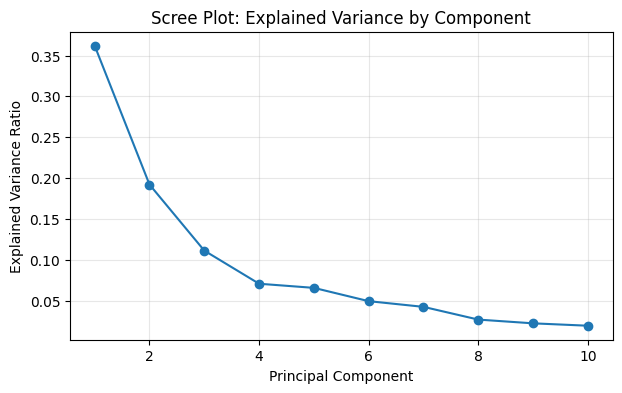

In [22]:
# ---- 7) Scree plot ----
plt.figure(figsize=(7,4))
plt.plot(range(1, len(explained)+1), explained, marker="o")
plt.title("Scree Plot: Explained Variance by Component")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.grid(True, alpha=0.3)
plt.show()

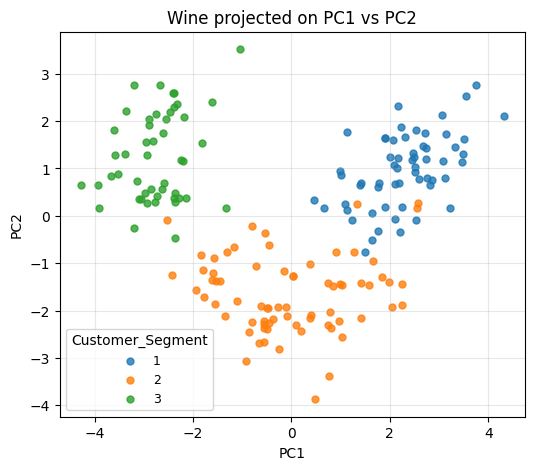

In [24]:
# ---- 8) 2D scatter of first two PCs, colored by label if available ----
plt.figure(figsize=(6,5))
if X_pca.shape[1] >= 2:
    if y is not None:
        # Encode y for coloring while keeping a legend
        y_vals = pd.Series(y)
        classes = y_vals.astype(str).unique()
        for cls in classes:
            mask = (y_vals.astype(str) == str(cls))
            plt.scatter(X_pca[mask, 0], X_pca[mask, 1], s=25, label=str(cls), alpha=0.8)
        plt.legend(title=target_col, fontsize=9)
    else:
        plt.scatter(X_pca[:, 0], X_pca[:, 1], s=25, alpha=0.8)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Wine projected on PC1 vs PC2")
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Only one principal component was retained; skipping 2D scatter.")


Top contributors to PC1 (by absolute loading):


Flavanoids              0.422934
Total_Phenols           0.394661
OD280                   0.376167
Proanthocyanins         0.313429
Nonflavanoid_Phenols    0.298533
Hue                     0.296715
Proline                 0.286752
Malic_Acid              0.245188
Ash_Alcanity            0.239320
Alcohol                 0.144329
Name: PC1, dtype: float64

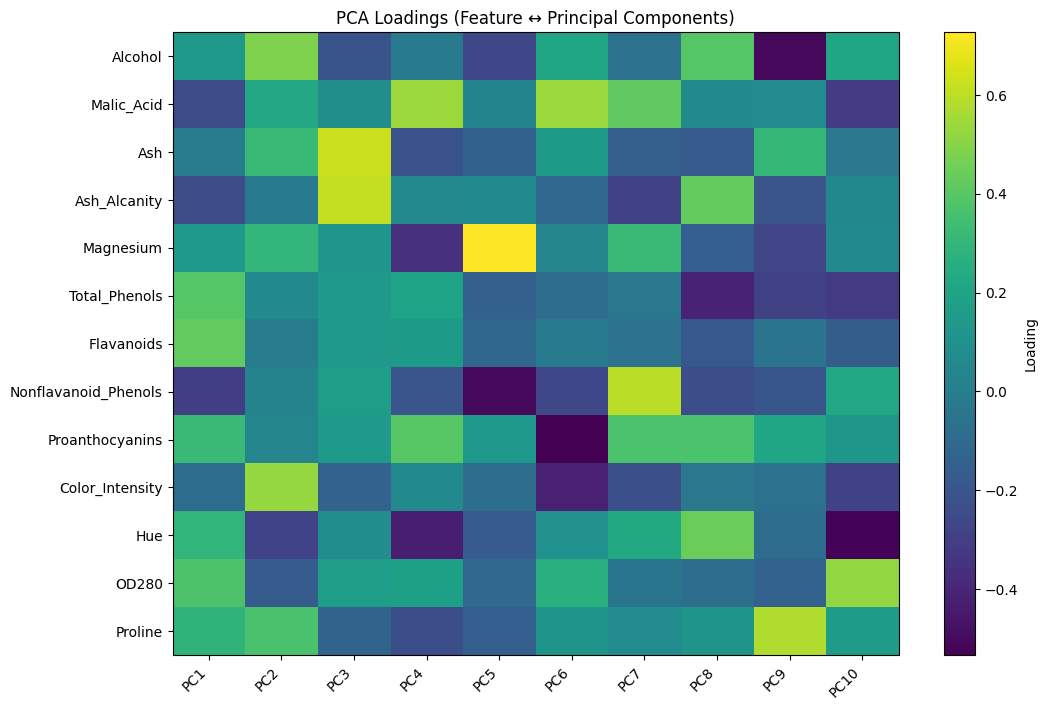

In [26]:
# ---- 9) Feature loadings (how strongly each original variable contributes) ----
# Loadings = eigenvectors scaled by sqrt(eigenvalues). In sklearn, components_ are eigenvectors.
loadings = pca.components_.T  # shape: [n_features, n_components]
load_df = pd.DataFrame(loadings, index=X.columns, columns=pcs_cols)

print("\nTop contributors to PC1 (by absolute loading):")
display(load_df["PC1"].abs().sort_values(ascending=False).head(10))

# Heatmap-style visualization of loadings (matplotlib only)
plt.figure(figsize=(min(1.1*len(pcs_cols), 12), min(0.4*len(X.columns)+2, 14)))
plt.imshow(load_df.values, aspect='auto', interpolation='nearest')
plt.colorbar(label="Loading")
plt.yticks(range(len(load_df.index)), load_df.index)
plt.xticks(range(len(load_df.columns)), load_df.columns, rotation=45, ha="right")
plt.title("PCA Loadings (Feature ↔ Principal Components)")
plt.tight_layout()
plt.show()


In [28]:
# ---- 10) Quick separation check along PC1/PC2 ----
if y is not None and X_pca.shape[1] >= 2:
    # Group means on PCs by class
    grp = pca_df.groupby(target_col)[["PC1","PC2"]].mean().sort_values("PC1")
    print("\nGroup means on (PC1, PC2):")
    display(grp)
    # If it's Red/White, you can visually inspect if clusters separate on PC1/PC2


Group means on (PC1, PC2):


,PC1,PC2
Customer_Segment,,
3,-2.748200,1.241308
2,-0.038986,-1.643483
1,2.282739,0.967874
